## Load the dataset

In [102]:
# Import standard library for preprocessing
import nltk
import re
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import scipy
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np

dataset = pd.read_csv('Hotel_Reviews_Compact.csv') # Big dataset
# dataset = pd.read_csv('Datafiniti_Hotel_Reviews_Jun19.csv') # Middle
# dataset = pd.read_csv('Datafiniti_Hotel_Reviews.csv') # Middle dataset

# Get rid of unsed columns and change into readable comfortable manner
dataset = dataset.drop(columns = ['address', 'categories', 'city', 'country', 'latitude', 'longitude', 'name', 'postalCode', 'province', 'reviews.date', 'reviews.dateAdded', 'reviews.doRecommend', 'reviews.id', 'reviews.title', 'reviews.userCity', 'reviews.username', 'reviews.userProvince'])
dataset = dataset.rename(columns = {'reviews.rating': 'Sentiment', 'reviews.text': 'Text'})

# If the rating is equal to 3 or more it is a good review, otherwise bad
dataset['Sentiment'] = dataset['Sentiment'].map(lambda x: 1 if x >= 3.5 else 0)
positive = dataset[dataset['Sentiment'] == 1]
negative = dataset[dataset['Sentiment'] == 0]
print(positive.shape, negative.shape)
dataset.head()

(22915, 2) (12997, 2)


,Sentiment,Text
0,1,Pleasant 10 min walk along the sea front to th...
1,1,Really lovely hotel. Stayed on the very top fl...
2,1,Ett mycket bra hotell. Det som drog ner betyge...
3,1,We stayed here for four nights in October. The...
4,1,We stayed here for four nights in October. The...


## Data preprocessing

In [103]:
# Global variables
stemming = PorterStemmer()
wnl = WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')
stopwords_in_regex = ' | '.join(stopwords)

# Params: String
# Return: String
def remove_stopwords(string):
    # Get all stopwords in English language
    stopwords_in_regex = ' | '.join(stopwords)
    string = re.sub(rf'({stopwords_in_regex})', ' ', string)
    return string

# Params: String
# Returns: Tokens (array of string)
def tokenize_string(string):
    tokens = nltk.word_tokenize(string)
    return tokens

# Params: Tokenized string
# Returns: String
def stemm_string(tokens):
    stemmed_tokens = []
    for token in tokens:
        stemmed_tokens.append(stemming.stem(token))
    return ' '.join(stemmed_tokens)

# Params: Tokenized string
# Returns: String
def lemmatize_string(tokens):
    lemmatized_tokens = []
    for token in tokens:
        lemmatized_tokens.append(wnl.lemmatize(token))
    return ' '.join(lemmatized_tokens)

# Params: Tokenizes string
# Returns: String
def stemm_lemmatize_string(string):
  string = re.sub(rf'({stopwords_in_regex})', ' ', string)
  tokenized_string = tokenize_string(string)
  stemm_lemm_tokens = []
  for token in tokenized_string:
    stemm_token = stemming.stem(token)
    lemm_stemm_token = wnl.lemmatize(stemm_token)
    stemm_lemm_tokens.append(lemm_stemm_token)
  return ' '.join(stemm_lemm_tokens)

# Params: String
# Return: String
def preprocess_string(row):

    # Lowers the uppercase characters
    row = str(row).lower()

    # In string removes characters inside '<' and '>' including '<' and '>'
    row = re.sub(r'\<[^<>]*\>', '', row)

    # Removes all characters that is not from A-Z and a-z and occures 1 or more times (removes punctuations)
    row = re.sub(r'[^A-Za-z ]+', '', row)
    
    # Remove double spaces
    row = re.sub(r'  *', ' ', row)


    # Stem and Lemm string
    row = stemm_lemmatize_string(row)

    return row

## Preprocess the text

In [104]:
dataset['Text'] = dataset['Text'].map(lambda x: preprocess_string(x))

In [105]:
dataset.head()

,Sentiment,Text
0,1,pleasant min walk along sea front the water bu...
1,1,realli love hotel stay the top floor were surp...
2,1,ett mycket bra hotel det som drog ner betyget ...
3,1,we stay for four night octob hotel staff welco...
4,1,we stay for four night octob hotel staff welco...


## Split data

In [106]:
x_train, x_test, y_train, y_test = train_test_split(dataset['Text'], dataset['Sentiment'], test_size = 0.3)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(25138,) (10774,) (25138,) (10774,)


## Defining the models

In [107]:
from sklearn.pipeline import Pipeline

tfidf_vec = TfidfVectorizer()
count_vec = CountVectorizer()
# Logistic regression
lgr = LogisticRegression(max_iter=1100)

model = Pipeline([('vectorizer', tfidf_vec), ('classifier', lgr)])

# SVM with kernel
svm_lin = svm.SVC(kernel='linear', C=1.0)
model_svm = Pipeline([('vectorizer', tfidf_vec), ('classifier', svm_lin)])

# Naive Bayes
nb = MultinomialNB()
model_nb = Pipeline([('vectorizer', count_vec), ('classifier', nb)])

model.fit(x_train, y_train)
model_svm.fit(x_train, y_train)
model_nb.fit(x_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', MultinomialNB())])

## Testing the model

In [108]:
example_text = ["Lovely clean room, breakfast was absolutely fantastic and everyone was really friendly",
               "The hotels treat you like garbage if you book through booking.com. I've booked through them a few times and have only recently just realised I get downgraded on stuff with the hotel if my reservation is through booking.com. The crappiest rooms, no parking available, rooms not being serviced, amenities a disappointment.. The list goes on.. Plus you pay more!! Next time I'll just book through the hotel itself. It's cheaper and you get treated better"] 
# from booking.com
example_result = model.predict(example_text)
print(f"Logistic Regression: {example_result}")

example_result = model_svm.predict(example_text)
print(f"SVM: {example_result}")

example_result = model_nb.predict(example_text)
print(f"NB: {example_result}")

Logistic Regression: [1 0]
SVM: [1 0]
NB: [1 0]


## Result printer

In [109]:
def get_results(inp_model):
	last_words = inp_model.predict(x_test)
	conf_matrix = confusion_matrix(last_words, y_test)
	a_score = accuracy_score(last_words, y_test)
	pre_score = precision_score(last_words, y_test, average = 'weighted')
	rec_score = recall_score(last_words, y_test, average = 'weighted')
	f1_score = 2 * (pre_score * rec_score) / (pre_score + rec_score)
	print("Confusion matrix: ", conf_matrix)
	print("Accuracy : ", a_score)
	print("Precision : ", pre_score)
	print("Recall : ", rec_score)
	print("F1 : ", f1_score)
	plot_confusion_matrix(inp_model, x_test, y_test)
	plt.show()

Logistic Regression:
Confusion matrix:  [[2632  733]
 [1320 6089]]
Accuracy :  0.8094486727306479
Precision :  0.82179243173524
Recall :  0.8094486727306479
F1 :  0.8155738490245873


/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


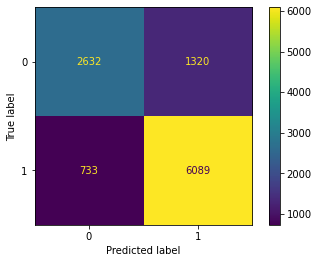


SVM:
Confusion matrix:  [[2687  776]
 [1265 6046]]
Accuracy :  0.8105624651939856
Precision :  0.8199276938680213
Recall :  0.8105624651939856
F1 :  0.8152181834753512


/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


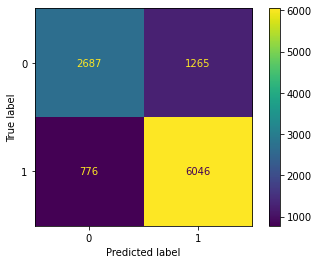


NB:
Confusion matrix:  [[2680  894]
 [1272 5928]]
Accuracy :  0.7989604603675515
Precision :  0.8056551278595291
Recall :  0.7989604603675515
F1 :  0.8022938285964542


/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


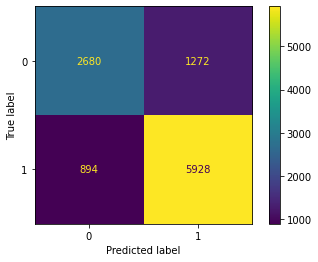

In [110]:
print("Logistic Regression:")
get_results(model)

print("\nSVM:")
get_results(model_svm)

print("\nNB:")
get_results(model_nb)

## Save the model to the file

In [111]:
import pickle
def save_file(filename, model):
	pickle.dump(model, open(filename, 'wb'))

save_file('log_trained.sav', model)
save_file('svm_trained.sav', model_svm)
save_file('nb_trained.sav', model_nb)
